In [1]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out

In [3]:
# Toy problem data
input_size = 256  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 256  
sequence_length = 160  # number of sequences/ number of rows
batch_size = 1
num_epochs = 2000

### importing PINN solution

In [4]:
# Load the .mat file
v_data = scipy.io.loadmat('v.mat')
h_data = scipy.io.loadmat('h.mat')
x_data = scipy.io.loadmat('x.mat')

In [5]:
x = x_data['X']
u = h_data['h']

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [7]:
input_data = u[0:160,:]
target_data = u[1:161, :]

test_data = u[160, :]
#test_target = u[161:201, :]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (256,)
input data shape (160, 256)
Target data shape (160, 256)


In [8]:
# Convert data to tensors
input_tensor = torch.tensor(input_data).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 160, 256])
Target tensor shape torch.Size([1, 160, 256])


In [9]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target).view(batch_size, 40, output_size).float()


In [10]:
# # Create LEM instance
# lem = LEM(input_size, hidden_size, output_size, dt=0.01)

# # Loss and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(lem.parameters(), lr=0.1)
# Create LEM instance :: niche h RNN vala 
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lem.parameters(), lr=0.01)



# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = lem(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}')




Epoch: 10/2000, Loss: 0.478989
Epoch: 20/2000, Loss: 0.306083
Epoch: 30/2000, Loss: 0.197181
Epoch: 40/2000, Loss: 0.131788
Epoch: 50/2000, Loss: 0.088712
Epoch: 60/2000, Loss: 0.062530
Epoch: 70/2000, Loss: 0.047468
Epoch: 80/2000, Loss: 0.039097
Epoch: 90/2000, Loss: 0.034614
Epoch: 100/2000, Loss: 0.032332


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 160, 256])) that is different to the input size (torch.Size([160, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 110/2000, Loss: 0.031220
Epoch: 120/2000, Loss: 0.030707
Epoch: 130/2000, Loss: 0.030486
Epoch: 140/2000, Loss: 0.030397
Epoch: 150/2000, Loss: 0.030363
Epoch: 160/2000, Loss: 0.030350
Epoch: 170/2000, Loss: 0.030345
Epoch: 180/2000, Loss: 0.030340
Epoch: 190/2000, Loss: 0.030325
Epoch: 200/2000, Loss: 0.030225
Epoch: 210/2000, Loss: 0.029811
Epoch: 220/2000, Loss: 0.028870
Epoch: 230/2000, Loss: 0.027680
Epoch: 240/2000, Loss: 0.026482
Epoch: 250/2000, Loss: 0.025352
Epoch: 260/2000, Loss: 0.024305
Epoch: 270/2000, Loss: 0.023341
Epoch: 280/2000, Loss: 0.022450
Epoch: 290/2000, Loss: 0.021624
Epoch: 300/2000, Loss: 0.020855
Epoch: 310/2000, Loss: 0.020137
Epoch: 320/2000, Loss: 0.019463
Epoch: 330/2000, Loss: 0.018830
Epoch: 340/2000, Loss: 0.018234
Epoch: 350/2000, Loss: 0.017670
Epoch: 360/2000, Loss: 0.017136
Epoch: 370/2000, Loss: 0.016629
Epoch: 380/2000, Loss: 0.016148
Epoch: 390/2000, Loss: 0.015690
Epoch: 400/2000, Loss: 0.015253
Epoch: 410/2000, Loss: 0.014836
Epoch: 4

### Exact solution

(1, 256)
(1, 201)
(201, 256)


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/matplotlib/contour.py:1180: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg).astype(np.float64)


<Figure size 432x288 with 0 Axes>

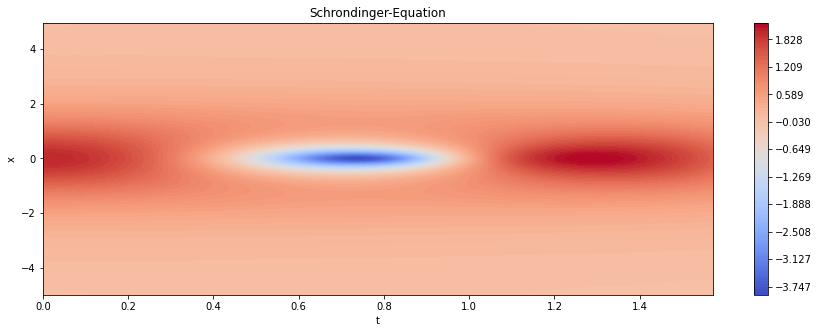

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['tt']
u1 = mat_data['uu']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u1), np.max(u1), 100)

# Plot the contour
plt.figure()
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u1.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Schrondinger-Equation')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [34]:
t

array([[0.        , 0.00785398, 0.01570796, 0.02356194, 0.03141593,
        0.03926991, 0.04712389, 0.05497787, 0.06283185, 0.07068583,
        0.07853982, 0.0863938 , 0.09424778, 0.10210176, 0.10995574,
        0.11780972, 0.12566371, 0.13351769, 0.14137167, 0.14922565,
        0.15707963, 0.16493361, 0.1727876 , 0.18064158, 0.18849556,
        0.19634954, 0.20420352, 0.2120575 , 0.21991149, 0.22776547,
        0.23561945, 0.24347343, 0.25132741, 0.25918139, 0.26703538,
        0.27488936, 0.28274334, 0.29059732, 0.2984513 , 0.30630528,
        0.31415927, 0.32201325, 0.32986723, 0.33772121, 0.34557519,
        0.35342917, 0.36128316, 0.36913714, 0.37699112, 0.3848451 ,
        0.39269908, 0.40055306, 0.40840704, 0.41626103, 0.42411501,
        0.43196899, 0.43982297, 0.44767695, 0.45553093, 0.46338492,
        0.4712389 , 0.47909288, 0.48694686, 0.49480084, 0.50265482,
        0.51050881, 0.51836279, 0.52621677, 0.53407075, 0.54192473,
        0.54977871, 0.5576327 , 0.56548668, 0.57

In [12]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 40, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 40, 256])


In [13]:
with torch.no_grad():
    prediction = lem(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(39):
        prediction = lem(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction
        


### Errors

### L2 norm

In [14]:
test_tensor.shape

torch.Size([1, 1, 256])

In [15]:
# true solution
h_true = np.abs(u1)
h_true = h_true.T
print(h_true.shape)

(201, 256)


In [16]:
# exact
u_test_full = h_true[161:201, :]
print(u_test_full.shape)

(40, 256)


In [17]:
# with torch.no_grad():
#     prediction = lem(test_tensor)

# prediction.shape

In [18]:

k1 = (prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
prediction_tensor.shape

torch.Size([1, 40, 256])

In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.0450293516989239 %


### Max error

In [20]:
R_abs = torch.max(prediction_tensor-u_test_full)
print(R_abs)

tensor(0.7530, dtype=torch.float64)


### Explained variance score

In [21]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())


Explained Variance Score: 0.9205719579800472


### Mean absolute error

In [22]:
R_mean = torch.mean(torch.abs(prediction_tensor - u_test_full))
print(R_mean)

tensor(0.1002, dtype=torch.float64)


In [23]:
## t= 1.28, 1.5, 1.37

### snapshots

In [24]:
prediction_tensor = torch.squeeze(prediction_tensor)
h = np.abs(u)
h.shape

(201, 256)

(256, 1)
(256, 1)


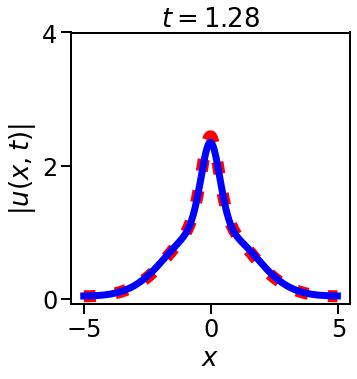

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# # Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)

final_time_output = prediction_tensor[-38, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = h[-38, :].reshape(-1, 1)
print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x.T, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x.T, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${|u(x, t)|}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 1.28}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-5, 0, 5])
ax.set_yticks([0, 2, 4])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


# Increase font size for x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=24)

# Set the legend
# ax.legend()

plt.savefig('LEM_1.28_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


(256, 1)
(256, 1)


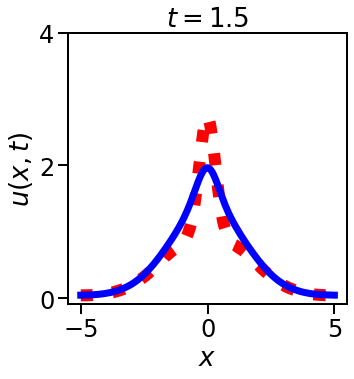

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# # Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)


final_time_output = prediction_tensor[-13, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = h[-13, :].reshape(-1, 1)
print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x.T, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x.T, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 1.5}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-5, 0, 5])
ax.set_yticks([0, 2, 4])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


# Increase font size for x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=24)

# Set the legend
# ax.legend()

plt.savefig('LEM_1.5_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


### 80-20 contour plot

In [27]:
conc_u = torch.squeeze(input_tensor)

In [28]:
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)

t1 = np.linspace(0, 1.5707 , 200)

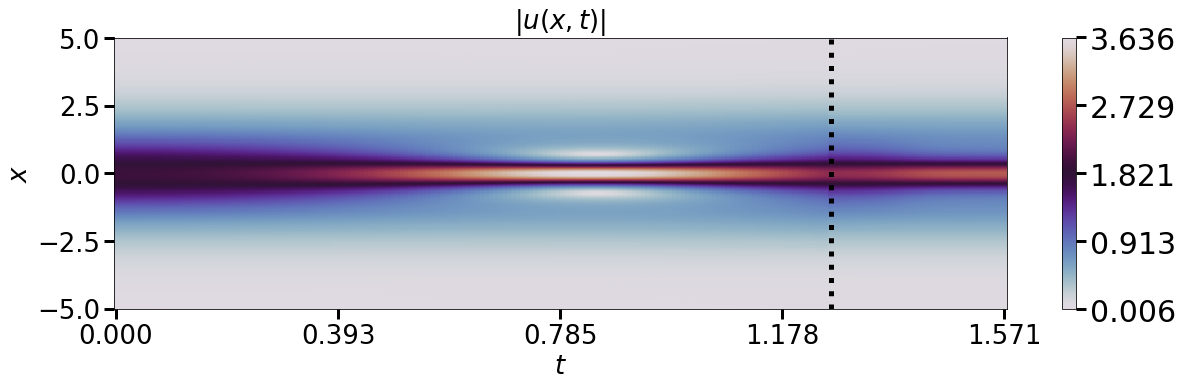

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(-5, 5, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1.57, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='twilight')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$|u(x, t)|$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=1.26449, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_LEM_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### exact contour

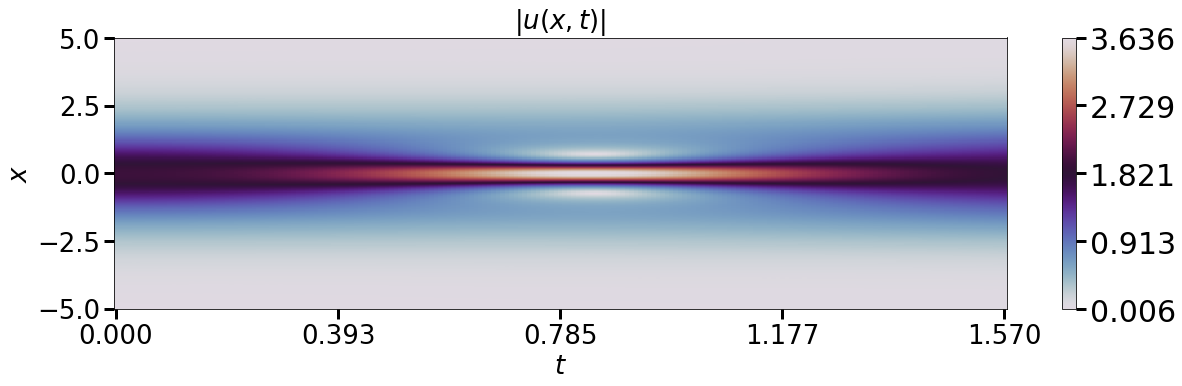

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = h

# Define custom color levels
x = np.linspace(-5, 5, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1.57, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='twilight')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$|u(x, t)|$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

#plt.savefig('Contour_Exact.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_exact.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()
